In [108]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [109]:
import numpy as np
import pandas as pd

In [110]:
from datetime import datetime as dt
import datetime

# Reflect Tables into SQLAlchemy ORM

In [111]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [112]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [113]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [114]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [115]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [116]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [117]:
inspector = inspect(engine)
columns = inspector.get_columns("measurement")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


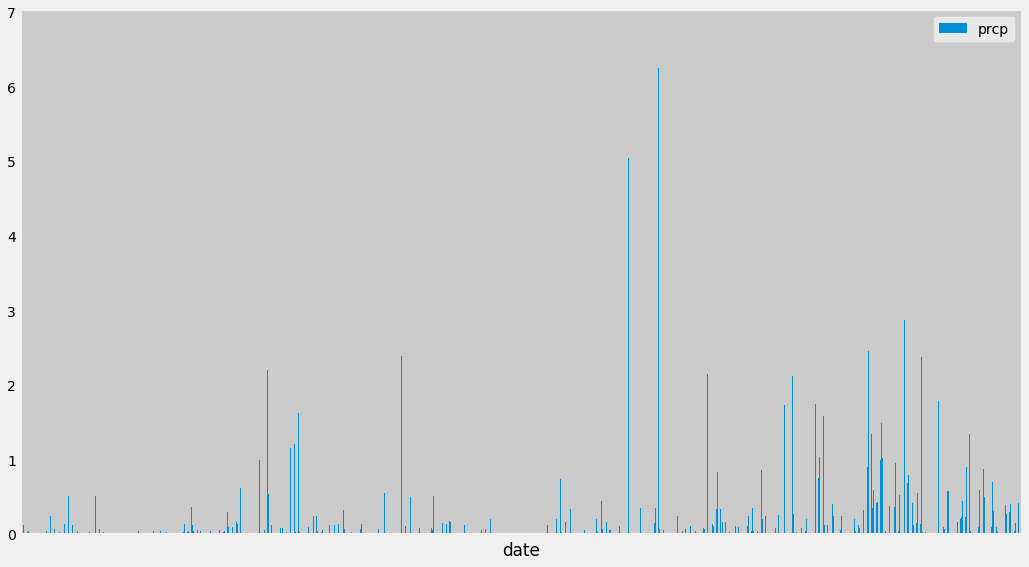

In [132]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
max_date = session.query(func.max(Measurement.date)).scalar()
#print(f"max_date - {max_date}")
max_dt = dt.strptime(max_date, "%Y-%m-%d")
max_last_year_dt = datetime.datetime(max_dt.year -1, max_dt.month, max_dt.day).date()
#print(f"max_last_year_dt - {max_last_year_dt}")

# Perform a query to retrieve the data and precipitation scores
rows = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= max_last_year_dt).all()
#print(rows)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(rows)
df.set_index("date", inplace=True,)

# Sort the dataframe by date
df.sort_index()
df.head(100)

#graph


#plt.tight_layout()
ax = df.plot(kind="bar", grid=True)
ax.set_xlabel("date")
ax.set_xticklabels("")
#ax.legend(("prcp", "precipitation"))
#ax.set_autoscalex_on(True)
#plt.figure(figsize=(100,50))
plt.rcParams["figure.figsize"] =[16, 9]
plt.show()

![precipitation](Images/precipitation.png)

In [119]:
# Use Pandas to calcualte the summary statistics for the precipitation data
#count = "{0:.6f}".format(df.count()[0])
count="{0:.6f}".format(df["prcp"].count())
mean="{0:.6f}".format(df["prcp"].mean())
std="{0:.6f}".format(df["prcp"].std())
min="{0:.6f}".format(df["prcp"].min())
quantile_25="{0:.6f}".format(df["prcp"].quantile(0.25))
quantile_50="{0:.6f}".format(df["prcp"].quantile(0.50))
quantile_75="{0:.6f}".format(df["prcp"].quantile(0.75))
max="{0:.6f}".format(df["prcp"].max())

#adding it to Dataframe
df_summary = pd.DataFrame( [["count", count], ["mean", mean], ["std", std], ["min", min], ["25%", quantile_25], ["50%", quantile_50], ["75%", quantile_75],  ["max", max]] , columns =["", "precipitation"])
df_summary.set_index("", inplace=True)
df_summary.head(10)




,precipitation
,
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [120]:
# Design a query to show how many stations are available in this dataset?
columns = inspector.get_columns("Station")
for c in columns:
    print(c["name"], c["type"])

rows = session.query(Station.id).all()

df_station = pd.DataFrame(rows)
df_station.head(100)

count=df_station["id"].count()
print(f"Number of stattions - {count}")

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
Number of stattions - 9


In [121]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

measures = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()

for measure in measures:
    (station, count) = measure
    print(f"Station {station} counts {count}")
    
active_station =  measures[0][0]   
print(f"Most active station_name -- {active_station}")


Station USC00519281 counts 2772
Station USC00519397 counts 2724
Station USC00513117 counts 2709
Station USC00519523 counts 2669
Station USC00516128 counts 2612
Station USC00514830 counts 2202
Station USC00511918 counts 1979
Station USC00517948 counts 1372
Station USC00518838 counts 511
Most active station_name -- USC00519281


In [122]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

min_temp = session.query(func.min(Measurement.prcp)).filter(Measurement.station==active_station).all()
print(f"Lowest temperature recorded for active station {active_station} is {min_temp[0][0]}")

max_temp = session.query(func.max(Measurement.prcp)).filter(Measurement.station==active_station).all()
print(f"Lowest temperature recorded for active station {active_station} is {max_temp[0][0]}")

avg_temp = session.query(func.avg(Measurement.prcp)).filter(Measurement.station==active_station).all()
print(f"Average temperature recorded for active station {active_station} is {avg_temp[0][0]}")

Lowest temperature recorded for active station USC00519281 is 0.0
Lowest temperature recorded for active station USC00519281 is 9.64
Average temperature recorded for active station USC00519281 is 0.2123520923520915


Station Highest number of temperature observation -- USC00519397
no. of rows -- tobs    352
dtype: int64


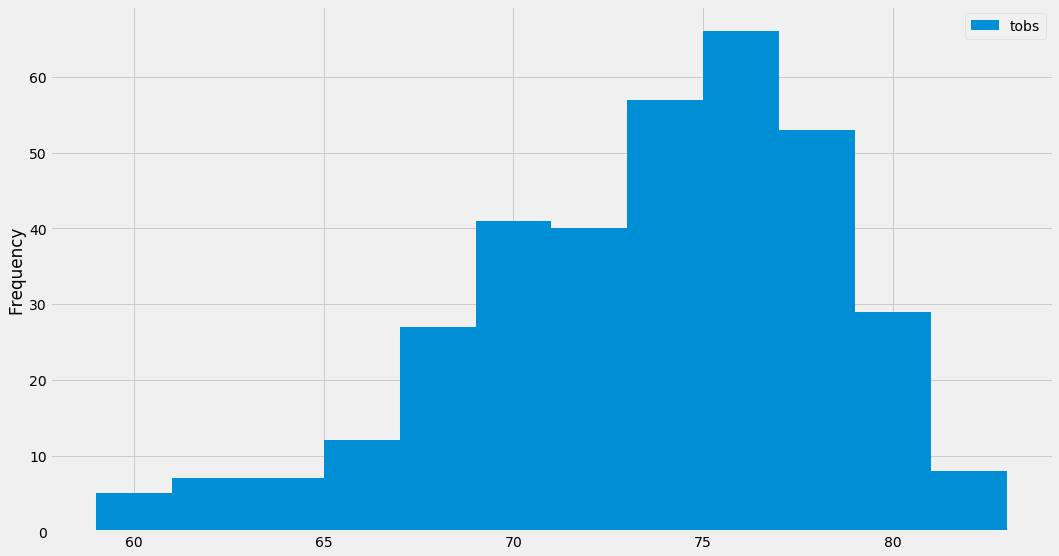

In [123]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
import matplotlib.mlab as mlab

total_obs = session.query(Measurement.station, func.sum(Measurement.tobs)).group_by(Measurement.station).order_by(func.sum(Measurement.tobs).desc()).all()
high_tobs_station = total_obs[0][0]
print(f"Station Highest number of temperature observation -- {high_tobs_station}")

rows = session.query(Measurement.tobs).filter(Measurement.date >= max_last_year_dt, Measurement.station==active_station).all()
df_hist = pd.DataFrame(rows)
print(f"no. of rows -- {df_hist.count()}")
num_bins=12

#Graph Info
plt.hist(df_hist["tobs"], num_bins)

plt.ylabel("Frequency")
plt.legend(("tobs", "tobs"))
plt.legend
#plt.rcParams["figure.figsize"] =[16, 9]
plt.show()
plt.tight_layout()

![precipitation](Images/station-histogram.png)

In [124]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [125]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date = "2016-12-20"
trip_end_date = "2016-12-28"


cal_values = calc_temps(trip_start_date, trip_end_date)

print(f"Minimum Temp. of trip -- {cal_values[0][0]}")
print(f"Average Temp. of trip -- {cal_values[0][1]}")
print(f"Maximum Temp. of trip -- {cal_values[0][2]}")

Minimum Temp. of trip -- 68.0
Average Temp. of trip -- 72.84482758620689
Maximum Temp. of trip -- 78.0


In [126]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [127]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [128]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [129]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [130]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [131]:
# Plot the daily normals as an area plot with `stacked=False`
